# Comparison among the different analysis types

In [1]:
import toml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from app.task import load_data, compute_expression_percs, get_output_df, get_output_list

# Loading parameters from TOML file
toml_file = "pyproject.toml"
config = toml.load(toml_file)
params = config["tool"]["flwr"]["app"]["config"]
num_partitions = config["tool"]["flwr"]["federations"]["local-simulation"]["options"]["num-supernodes"]


## Federated analysis

Here we read the results of the FL process and show the results.

In [2]:
# Read the output of the federated analysis
ndarrays = np.load("output.npy", allow_pickle=True)

# Identify weakly expressed genes
df_out = get_output_df(ndarrays)
list_out = get_output_list(df_out, params["expr_perc"])

# Print results
print("\nPercentage of individuals where gene is expressed less than threshold:\n", df_out.to_string(index=False), "\n")
print("\nWeakly expressed genes:", list_out)



Percentage of individuals where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  Gene_8  Gene_9  Gene_10
   89.0     3.0     0.0    95.0     7.0    79.0     3.0     0.0     5.0      0.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6']


## Centralized analysis

Here, we aggregate the datasets from the different clients participating in the FL process and perform the analysis in a centralized manner. Note that the results are <b>identical</b> to those obtained through FL. However, it's important to note that this approach would not be feasible in a real-world scenario where only FL is authorized.

In [3]:
# Concatenate all partitions into a single dataset
all_partitions = []
for i in range(num_partitions):  
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_genes = params["num_genes"], seed_value = params["seed_value"])
    data["Client"] = i
    all_partitions.append(data)
merged_dataset = pd.concat(all_partitions)
#print(merged_dataset.head())

# Identify weakly expressed genes
percs = compute_expression_percs(merged_dataset.iloc[:,:-1], params["expr_thr"])
df_out = get_output_df([percs])
list_out = get_output_list(df_out, params["expr_perc"])

# Print results
print("\nPercentage of samples where gene is expressed less than threshold:\n", df_out.to_string(index=False), "\n")
print("\nWeakly expressed genes:", list_out)



Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  Gene_8  Gene_9  Gene_10
   89.0     3.0     0.0    95.0     7.0    79.0     3.0     0.0     5.0      0.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6']


## Local analysis

Here, we present the results each client would obtain by analyzing their dataset independently. Notably, using the default seed value from the configuration file, the set of weakly expressed genes identified by <b>Client 1</b> does not align with the overall set of weakly expressed genes across all clients.

In [4]:
for i in range(num_partitions):
    # Load a partition
    data = load_data(i, num_partitions, params["num_individuals"], 
                     num_genes = params["num_genes"], seed_value = params["seed_value"])

    # Identify weakly expressed genes
    percs = compute_expression_percs(data, params["expr_thr"])
    df_out = get_output_df([percs])
    list_out = get_output_list(df_out, params["expr_perc"])
    
    # Print results
    print("--- Client", i, "---")
    print("\nPercentage of samples where gene is expressed less than threshold:\n", df_out.to_string(index=False), "\n")
    print("\nWeakly expressed genes:", list_out, "\n")

--- Client 0 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  Gene_8  Gene_9  Gene_10
   90.0    10.0     0.0    85.0    15.0    80.0     0.0     0.0    10.0      0.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6'] 

--- Client 1 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  Gene_8  Gene_9  Gene_10
   95.0     0.0     0.0   100.0     5.0    60.0     0.0     0.0     5.0      0.0 


Weakly expressed genes: ['Gene_1', 'Gene_4'] 

--- Client 2 ---

Percentage of samples where gene is expressed less than threshold:
  Gene_1  Gene_2  Gene_3  Gene_4  Gene_5  Gene_6  Gene_7  Gene_8  Gene_9  Gene_10
   90.0     0.0     0.0   100.0     5.0    80.0    10.0     0.0     5.0      0.0 


Weakly expressed genes: ['Gene_1', 'Gene_4', 'Gene_6'] 

--- Client 3 ---

Percentage of samples where gene is expressed less than threshold:
 

## Visual comparison for local and centralized analyses

The following two plots provide an overview of gene expression levels across the different local client datasets as well as the overall dataset. Notice again that, with the seed value used in the configuration file, Gene_6 would not be considered as weakly expressed by Client 1 in the local analysis but would be considered weakly expressed in the overall dataset.

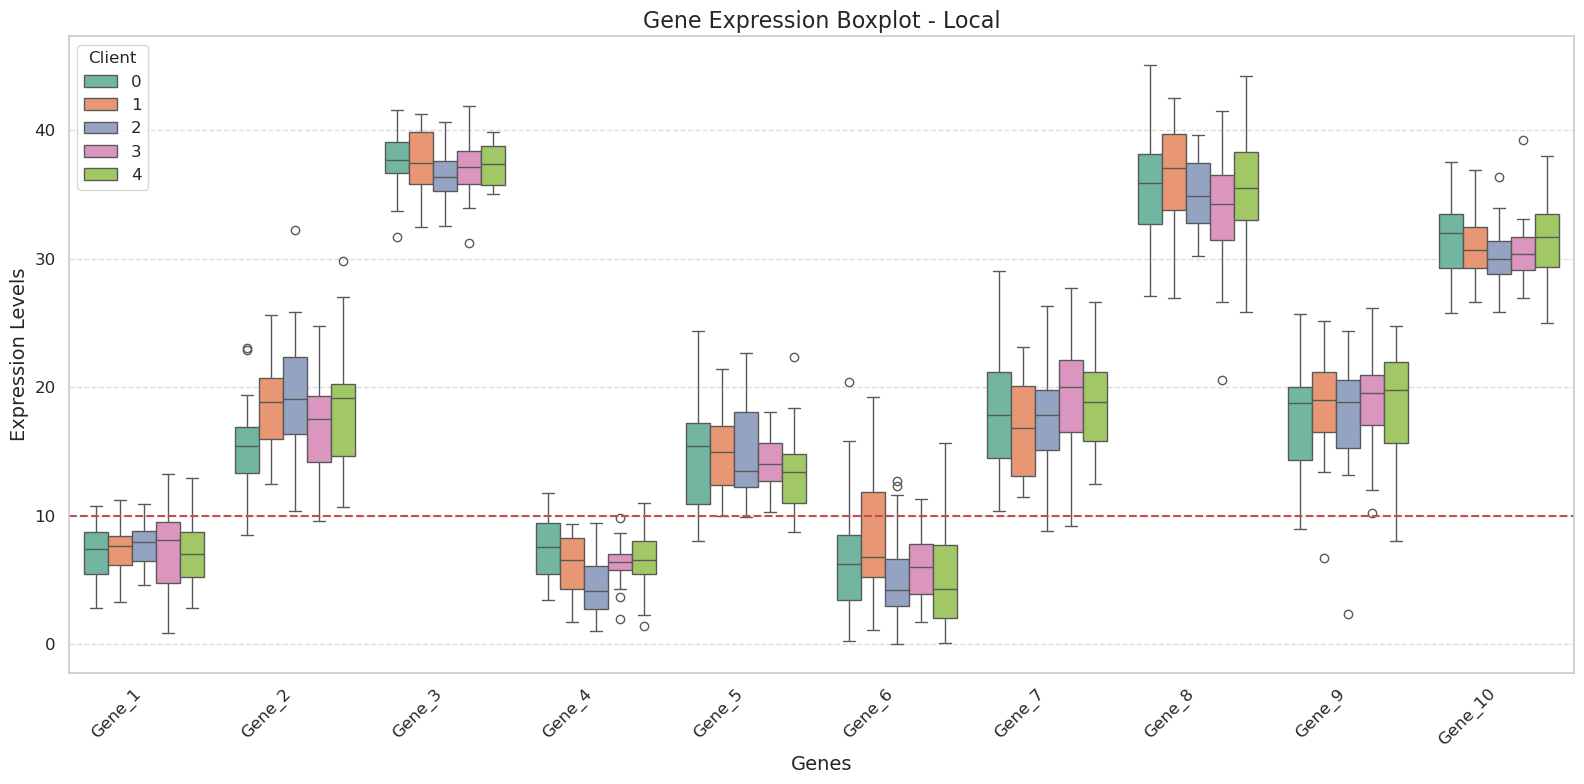

In [7]:
# Melt centralized dataset for plotting
gene_data = merged_dataset.melt(id_vars=["Client"], value_name="Expression", var_name="Gene")

# Create boxplot
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
sns.boxplot(x="Gene", y="Expression", hue="Client", data=gene_data, palette="Set2")

# Add horizontal line at reference expression value
plt.axhline(y=params["expr_thr"], color='r', linestyle='--')

# Customize plot
plt.xlabel("Genes", fontsize=14)
plt.ylabel("Expression Levels", fontsize=14)
plt.title("Gene Expression Boxplot - Local", fontsize=16)
plt.xticks(rotation=45, ha="right", fontsize=12)  
plt.yticks(fontsize=12)  
plt.legend(title="Client", fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout() 
plt.show()


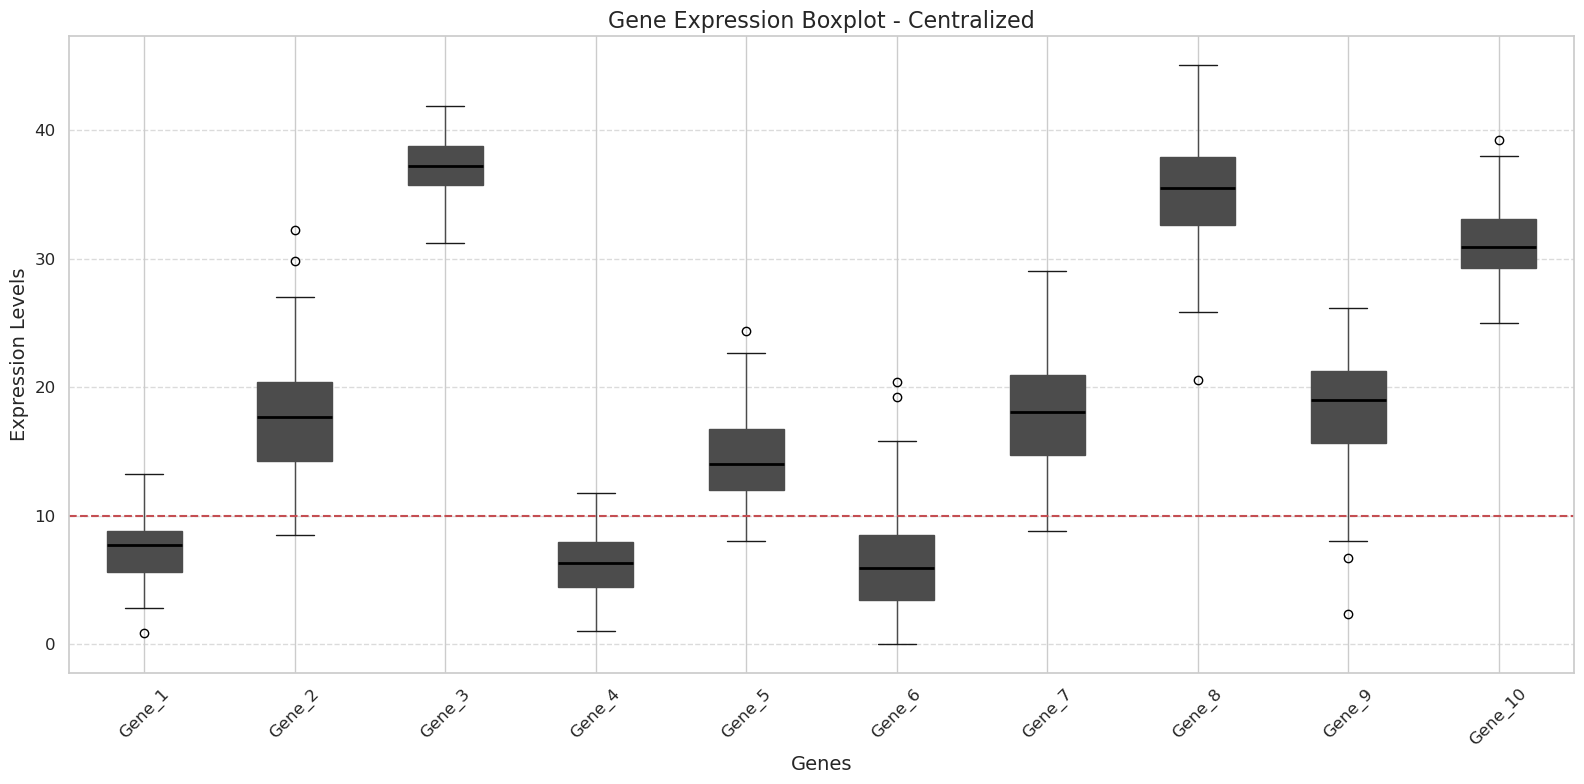

In [11]:
# Drop client column for plotting
gene_data = merged_dataset.iloc[:, :-1]  

# Create boxplot
plt.figure(figsize=(16, 8))
sns.set(style="whitegrid")
gene_data.boxplot(rot=45, patch_artist=True, medianprops=dict(color='black', linewidth=2))

# Add horizontal line at reference expression value
plt.axhline(y=params["expr_thr"], color='r', linestyle='--')

# Customize plot
plt.xlabel("Genes", fontsize=14)
plt.ylabel("Expression Levels", fontsize=14)
plt.title("Gene Expression Boxplot - Centralized", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()
